# Лекция 5-6. Линейная регрессия


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn')
%matplotlib inline

C:\Users\Jane\AppData\Local\Temp\ipykernel_13504\3651752339.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


In [2]:
import os
os.chdir("C:\\Users\\Jane\\Documents\\!myAD\\2023\\DataSets")

## Пример 5.1 Предсказание цены домов в г. Альбукерке

**Датасет**: случайная выборка из 117 записей о продажах домов, совершенных между 15 февраля и 30 апреля 1993. Информация предоставлена Советом риэлтеров (Albuquerque Board of Realtors) г. Альбукерка, США.

**Описание данных**:
* PRICE - продажная цена в сотнях долларов;
* SQFT - площадь в квадратных футах;
* AGE - возраст дома (количество лет);
* FEATS - количество дополнительных удобств из 11 возможных: dishwasher (посудомоечная машина), refrigerator (холодильник), microwave (СВЧ-печ), disposer (измельчитель отходов), washer (стиральная машина), intercom (домофон), skylight(s) (мансардное окно(а)), compactor (уплотнитель бытовых отходов), dryer (сушилка), handicap fit (приспособлено для инвалидов), cable TV access (доступ к кабельному ТВ);
* NE - дом расположен в престижном районе на северо-востоке города (1), или нет (0);
* CUST - тип постройки: был ли дом стандартной постройки или нет;
* COR - как расположен дом, на углу (1) или нет (0).
* TAX - величина налогов за владение домом ($).

**Задача**: построить модель, позволяющую по задаваемому набору параметров спрогнозировать цену дома.

In [3]:
df_albuq = pd.read_csv('Albuquerque Home Prices.txt', sep='\t')
df_albuq.head()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13,7,1,1,0,1639
1,2080,2600,-9999,4,1,1,0,1088
2,2150,2664,6,5,1,1,0,1193
3,2150,2921,3,6,1,1,0,1635
4,1999,2580,4,4,1,1,0,1732


In [4]:
print(df_albuq.shape)

(117, 8)


## I. Первичный анализ набора данных

Значения -9999 в современных обозначениях соответствуют ```NaN``` (знгачение не определено, пропуск). Проведем замены этих значений в считанном датасете, исследуем характер их вхождения, решим, что делать с такими пропусками.

In [5]:
df_albuq = df_albuq.replace(-9999, np.nan)
df_albuq.head()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13.0,7,1,1,0,1639.0
1,2080,2600,NaN,4,1,1,0,1088.0
2,2150,2664,6.0,5,1,1,0,1193.0
3,2150,2921,3.0,6,1,1,0,1635.0
4,1999,2580,4.0,4,1,1,0,1732.0


**1. Проанализируем, много ли строк содержат пропуски.**

Обратите внимание на форматированный вывод в Python внутри функции ```print()```.

Функция ```df.dropna()``` удаляет строки, содержащие значения ```NaN```. 

Параметр ```how``` определяет, к какой записи применять функцию: ```how='any'``` - ко всем записям, содержащим хотя бы в одном столбце ```NaN``` (по умолчанию); ```how='all'``` - толькор те строки, в которых значения всех столюцов не определены. 

Следует ли изменять DataFrame вместо создания нового определяется параметром ```inplace```. Если ```inplace=True```, то удаление записей происходит в исходном DataFrame, иначе создается новый. По умолчанию ```inplace=False``` и изменений в исходном DataFrame не происходит. 

В напшем случае просто в ```df_albuq``` подсчитывается количество строк, не содержащих ```NaN```, при этом сам DataFrame не изменяется.

Подробнее про функцию ```df.dropna()``` можно посмотреть [здесь](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html#)

In [6]:
print('Rows without NAN: {0}'.format(len(df_albuq.dropna(how='any'))))
print('Rows in the data frame: {0}'.format(len(df_albuq)))


Rows without NAN: 66
Rows in the data frame: 117


Мы видим, что около половины записей содержат хотя бы одно пропущенное значение. Поскольку данных относительно мало, пренебрегать строками с пропусками не стоит.

**2. Выясним, сколько пропусков значений в каждом признаке (столбце).**

In [7]:
df_albuq.apply(lambda x: sum(x.isnull()), axis=0)

PRICE     0
SQFT      0
AGE      49
FEATS     0
NE        0
CUST      0
COR       0
TAX      10
dtype: int64

Метод ```DataFrame.apply()``` применяет функцию, указанную в первом аргументе, ко всему датафрейму в направлении, указанном в аргументе ```axis```. Если ```axis=0```, то функция применяется к каждому столбцу, если ```axis=1```, то к каждой строке.

Часто в качестве функции удобно указывать код в виде [lambda-функцией](https://pythonist.ru/lambda-funkczii-v-python-s-ih-sintaksisom-i-primerami/). ```Lambda```-функция - это способ коротко (в одну строку) записать небольшую функцию, не задавая её имени. В данном случае лямбда-выражение эквивалентно следующему определению функции:

```def f(x):
    return sum(x.isnull())```
    
Метод ```df.isnull()```, примененный к DataFrame, возвращает DataFrame того же размера, что и исходный, содержащий значение ```True```, если в этом месте в исходном DataFrame быд пропуск (```NaN```) и ```False``` во всех остальных случаях. Функция ```sum``` - это встроенная функция Python, подсчитывающая сумму членов последовательности, отсюда следует, что в качестве аргумента ```x``` следует указывать либо столбец либо строку фрейма, что и происходит по синтаксису метода ```DataFrame.apply()```.

Документацию смотри [здесь](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) и [здесь](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)

Таким образом, представленный в ячейке 7 код подсчитывает количество пропущенных значений в каждом столбце ```df_albuq```.

Выполнив код, мы видим, что источниками пропущенных значений являются признаки ```AGE``` и ```TAX```. Более того, в колонке ```AGE``` так много пропусков, что проще совсем убрать информацию о возрасте дома из анализа, чем пытаться заделать эти дыры. Если этот признак существенный, то необходимо подумать о нестатистических способах его заполнения - восстановление половины значений признака с помощью методов анализа данных в большинстве случаев неоправдано.  

In [8]:
del df_albuq['AGE']

В то же время данные столбца ```TAX``` можно попробовать аппроксимировать. Чтобы это сделать, сначала посмотрим, как выглядит распределение значений этого признака.

<Axes: >

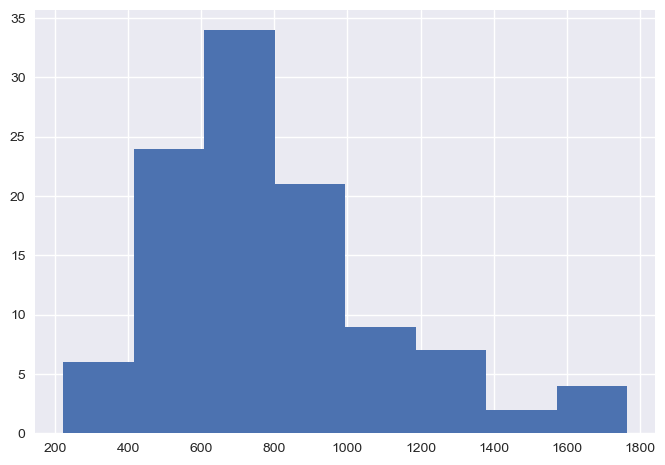

In [9]:
# поизменяйте значения параметра bins!
df_albuq['TAX'].hist(bins=8)

In [10]:
df_albuq['TAX'].describe(include='all')

count     107.000000
mean      793.485981
std       308.180276
min       223.000000
25%       600.000000
50%       731.000000
75%       919.000000
max      1765.000000
Name: TAX, dtype: float64

Конечно, распределение в столбце ```TAX``` имеет тяжелый 'хвост' вправо, однако медиана не сильно отличается от среднего. С некоторым сомнением признаем распределение налогов похожим на нормальное. Тогда можно заменить пропуски на среднее по столбцу значение. 

Для этого в pandas есть метод ```Series.fillna```, который заменяет все пропущенные в столбце значения на заданное.

<Axes: >

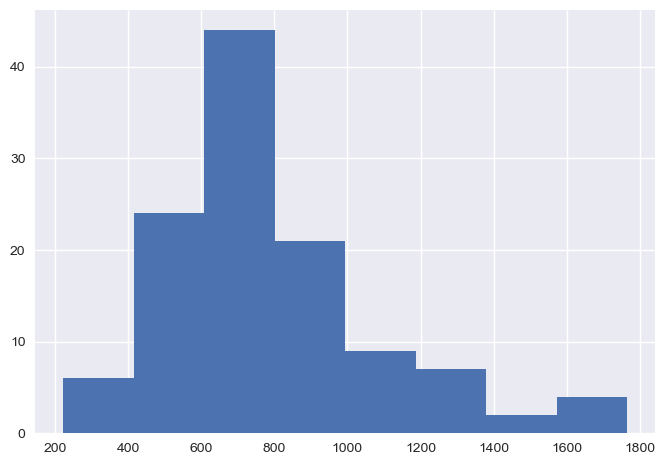

In [11]:
df_albuq['TAX'] = df_albuq['TAX'].fillna(df_albuq['TAX'].mean())
df_albuq['TAX'].hist(bins=8)

In [12]:
df_albuq['TAX'].describe(include='all')

count     117.000000
mean      793.485981
std       294.597310
min       223.000000
25%       600.000000
50%       752.000000
75%       899.000000
max      1765.000000
Name: TAX, dtype: float64

Убедимся, что все проблемы с пропусками устранены. Длина таблицы с пропусками равна длине исходного датасета.

In [13]:
len(df_albuq.dropna())

117

Составим общее представление о данных. Признаки ```PRICE```, ```SQFT```, ```FEATS``` и ```TAX``` числовые, а признаки ```NE```, ```CUST``` и ```COR``` следует считать номинальными, следовательно, использовать как группирующие. Проведем быстрое исследование на основе знакомого полотна графиков ```scatter_matrix```.

Для более тщательного представления о данных постройте график для всего ```df_albuq```; используйте другие подходящие группирующие переменные. Что вы можете сказать о данных? Можно ли признак ```FEATS``` сделать группирующим? Если да, то что нужно изменить в коде, чтобы попробовать разбить на классы по этому признаку? Можно ли признак ```TAX``` сделать группирующим? Если да, то что нужно изменить в коде, чтобы попробовать разбить на классы по этому признаку?

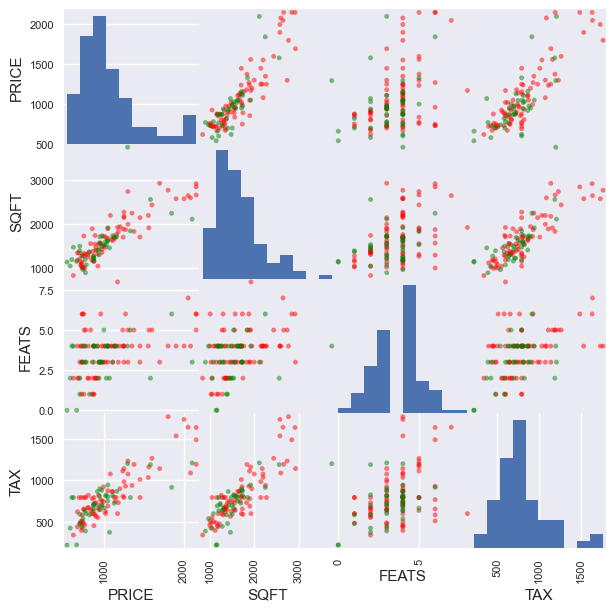

In [14]:
from pandas.plotting import scatter_matrix
colors = {0: 'green', 1: 'red'}
scatter_matrix(df_albuq[['PRICE','SQFT','FEATS','TAX']],
               # кол-во строк и столбцов в таблице
               figsize=(7,7),
               # ядерные оценки плотности 'kde' или гистограммы ('hist') на диагонали
               diagonal='hist',
               # цвета классов
               c=df_albuq['NE'].replace(colors),
               # степень прозрачности точек
               alpha=0.5,
              );

## II. Построение линейной модели

### II.1. Построение линейной модели с использованием модуля sklearn.linear_model


Для построения и использования обычной модели линейной регрессии, основанной на методе найменьших квадратов в модуле ```sklearn.linear_model``` используется класс ```LinearRegression```. Подробнее о свойствах и методах класса см. [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression).

Напомним, что  в ```scikit-learn``` принят следующий алгоритм настройки и использования моделей:
1. Инициализация модели, задание её параметров (вызов конструктора соответствующего класса).
2. Подгонка модели (метод fit и/или fit_transform).
3. Анализ результатов (доступ к свойствам объекта), предсказание для новых наблюдений (метод predict).

Такой алгоритм мы уже применяли в случае кластеризации с помощью _k_-средних. По аналогии будем действовать при построении линейной регрессии.

In [15]:
from sklearn.linear_model import LinearRegression

Определим независимые переменные регрессии (набор факторов) и ответную переменную (прогноз). В нашем случае мы собираемся прогнозировать цену продажи. В набор факторов пока включим все оставшиеся признаки.   

In [16]:
factors = df_albuq.drop('PRICE', axis=1)
response = df_albuq['PRICE']

1. **Инициализация модели** (объекта класса)

В большинстве случаев не требуется изменять параметры инициализации модели, предполагаемые по умолчанию. В случае центрированных (стандартизированных) данных следует задать параметр ```fit_intercept```, который определяет, используется ли в модели свободный член (ответ модели в случае, когда все входные признаки для наблюдения равны нулю). Если ```fit_intercept=True```, то свободный член для модели вычисляется (задано по умолчанию), иначе свободный член полагается равным 0. Аналитик должен самостоятельно предварительно центрировать данные, если это необходимо.

In [17]:
model = LinearRegression()

2. **Обучение модели**: получение коэффициентов регрессии.

In [18]:
model.fit(factors, response)

LinearRegression()

3. Применяя различные методы класса ```LinearRegression``` **анализируем** построенную модель.

    3.1. Считаем коэффициент детерминации $R^2$ (долю объясненной моделью дисперсии). В нашем случае доля считается от полной дисперсии ответной переменной на множестве обучающих примеров.

In [19]:
print('R^2: {0}'.format(model.score(factors, response)))

R^2: 0.8022436103807493


3.2. Выведем в виде таблицы регрессионные коэффициенты (методом ```model.coef_```) и свободный член (методом  ```model.intercept_```).
    
Обратите внимание на функцию ```zip```, которая в нашем случае формирует пары связанных значений (название признака, значение соответствующего коэффициента построенной линейной регрессии). Из этих пар формируется DataFrame для аккуратного понятного вывода.

In [20]:
coef = pd.DataFrame(zip(['intercept'] + factors.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,83.175919
1,SQFT,0.291978
2,FEATS,12.176743
3,NE,8.011604
4,CUST,133.014342
5,COR,-65.800841
6,TAX,0.541942


К сожалению, в ```sklearn``` не предусмотрена процедура определения статистической значимости регрессионных коэффициентов. Поэтому соответствующий код придется писать вручную, используя знания о распределении коэффициентов модели. 

При анализе иногда удобнее воспользоваться пакетом ```statsmodels```, в котором есть удобный метод ```summary```, предоставляющий целых три блока информации о построенной модели.

### II.2. Построение линейной модели с использованием модуля statsmodels. Анализ остатков

In [21]:
import statsmodels.formula.api as smf
#import statsmodels.graphics.api as smg
#import statsmodels.stats.api as sms
#from statsmodels.stats.descriptivestats import Description

In [22]:
model_linear_ols = smf.ols(formula='PRICE~SQFT+FEATS+NE+CUST+COR+TAX', data=df_albuq)
result_model_all = model_linear_ols.fit()
print(result_model_all.summary(alpha=0.05))

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     74.37
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           2.01e-36
Time:                        13:54:24   Log-Likelihood:                -765.84
No. Observations:                 117   AIC:                             1546.
Df Residuals:                     110   BIC:                             1565.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     83.1759     63.308      1.314      0.1

In [23]:
# вычисляем остатки и среднеквадратичную ошибку
# residual_all = pd.DataFrame()
residual_all = df_albuq.copy()

residual_all['forecast'] = result_model_all.predict(residual_all)
#residual_all['forecast1'] = result_model_all.params[0] + result_model_all.params[1]*residual_all['SQFT'] + result_model_all.params[2]*residual_all['FEATS'] + result_model_all.params[3]*residual_all['NE'] + result_model_all.params[4]*residual_all['CUST'] + result_model_all.params[5]*residual_all['COR'] + result_model_all.params[6]*residual_all['TAX']

residual_all['residuals'] = residual_all['forecast'] - residual_all['PRICE']
print(residual_all)

MSE_ols=np.sqrt(np.sum(residual_all['residuals']*residual_all['residuals'])/residual_all.shape[0])
print('MSE LSM:', MSE_ols)


     PRICE  SQFT  FEATS  NE  CUST  COR     TAX     forecast   residuals
0     2050  2650      7   1     1    0  1639.0  1971.423521  -78.576479
1     2080  2600      4   1     1    0  1088.0  1621.684194 -458.315806
2     2150  2664      5   1     1    0  1193.0  1709.451454 -440.548546
3     2150  2921      6   1     1    0  1635.0  2036.204977 -113.795023
4     1999  2580      4   1     1    0  1732.0  1964.855487  -34.144513
..     ...   ...    ...  ..   ...  ...     ...          ...         ...
112    872  1229      3   0     0    0   721.0   869.287195   -2.712805
113    870  1273      4   0     0    0   638.0   849.329747  -20.670253
114    869  1165      4   0     0    0   694.0   848.144920  -20.855080
115    766  1200      4   0     0    1   634.0   760.046761   -5.953239
116    739   970      4   0     0    1   541.0   642.491246  -96.508754

[117 rows x 9 columns]
MSE LSM: 168.4550588568736


<Axes: >

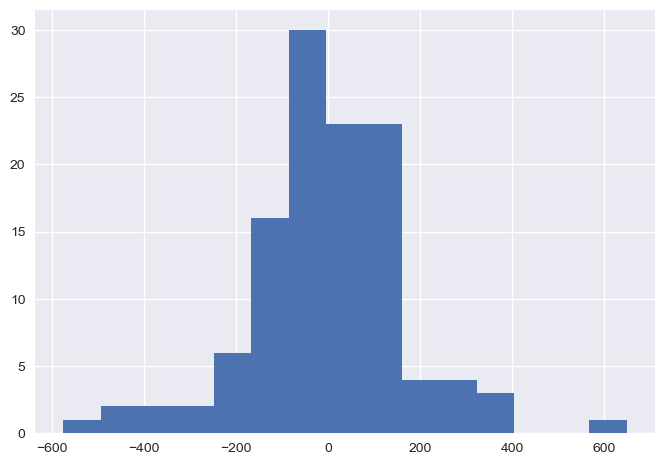

In [24]:
# нарисуем гистаграмму для остатков
residual_all['residuals'].hist(bins=15)

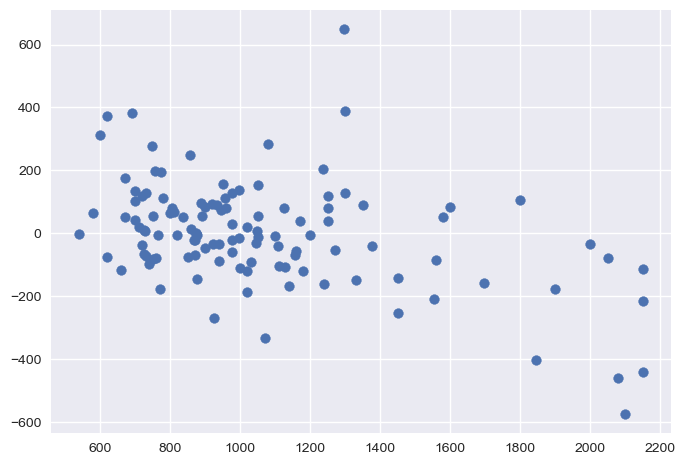

In [25]:
# нарисуем остатки в зависимости от цены
plt.scatter(residual_all['PRICE'],residual_all['residuals'])

In [26]:
# выведем описательную статистику остатков с помощью метода pandas
print("Описательная статистика остатков")
residual_all['residuals'].describe()

Описательная статистика остатков


count    1.170000e+02
mean    -2.098834e-13
std      1.691796e+02
min     -5.742464e+02
25%     -8.251470e+01
50%     -4.126732e+00
75%      8.406829e+01
max      6.493437e+02
Name: residuals, dtype: float64

In [27]:
# выведем подробную (список задается) описательную статистику остатков с помощью функции модуля statsmodels
from statsmodels.stats.descriptivestats import Description
print("Подробная описательная статистика остатков")
result = Description(
    residual_all['residuals'],
    stats=["nobs", "missing", "max", "min", "range", "median", "mean", "std_err", "ci", "ci", "std", "iqr", "mad", "coef_var", "skew", "kurtosis",
           "percentiles", "distinct", "top", "freq"],
    alpha=0.05,
    use_t=True)
display(result.summary())

Подробная описательная статистика остатков


nobs,117.0
missing,0.0
max,649.343688789774
min,-574.246359511601
range,1223.590048301375
median,-4.126731525252353
mean,-2.098833927168296e-13
std_err,15.640659561031162
upper_ci,30.978297021638678
lower_ci,-30.978297021639097
std,169.17960008812184


In [28]:
# дополнительная проверка остатков на нормальность с помощью различных критериев
from scipy import stats
print(stats.jarque_bera(residual_all['residuals']))
print(stats.normaltest(residual_all['residuals']))
print(stats.shapiro(residual_all['residuals']))
print(stats.kstest(residual_all['residuals'], 'norm'))

SignificanceResult(statistic=33.04885483175425, pvalue=6.660891457519387e-08)
NormaltestResult(statistic=11.630378210787336, pvalue=0.0029819163776798456)
ShapiroResult(statistic=0.9535768628120422, pvalue=0.00048177994904108346)
KstestResult(statistic=0.515702745181986, pvalue=1.9720688047601474e-29, statistic_location=-2.5323664350032686, statistic_sign=1)


In [29]:
df_albuq.corr()

,PRICE,SQFT,FEATS,NE,CUST,COR,TAX
PRICE,1.000000,0.844795,0.420272,0.167840,0.555292,-0.079293,0.844889
SQFT,0.844795,1.000000,0.394925,0.145030,0.520102,0.040528,0.832674
FEATS,0.420272,0.394925,1.000000,0.190016,0.241964,-0.041547,0.419473
NE,0.167840,0.145030,0.190016,1.000000,0.043033,-0.077336,0.189230
CUST,0.555292,0.520102,0.241964,0.043033,1.000000,-0.003994,0.444906
COR,-0.079293,0.040528,-0.041547,-0.077336,-0.003994,1.000000,-0.058329
TAX,0.844889,0.832674,0.419473,0.189230,0.444906,-0.058329,1.000000


In [30]:
model_linear_ols = smf.ols(formula='PRICE~SQFT+FEATS+NE+CUST+COR', data=df_albuq)
result_noTAX = model_linear_ols.fit()
print(result_noTAX.summary(alpha=0.05))

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     67.21
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           5.58e-32
Time:                        13:54:24   Log-Likelihood:                -779.15
No. Observations:                 117   AIC:                             1570.
Df Residuals:                     111   BIC:                             1587.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     73.4047     70.589      1.040      0.3

In [34]:
model_linear_ols = smf.ols(formula='SQFT~FEATS+NE+CUST+COR', data=df_albuq)
result_SQFTall = model_linear_ols.fit()
print(result_SQFTall.summary(alpha=0.05))

                            OLS Regression Results                            
Dep. Variable:                   SQFT   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     15.49
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           4.07e-10
Time:                        14:05:46   Log-Likelihood:                -872.28
No. Observations:                 117   AIC:                             1755.
Df Residuals:                     112   BIC:                             1768.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1092.6786    116.635      9.368      0.0

In [35]:
model_linear_ols = smf.ols(formula='SQFT~NE+COR', data=df_albuq)
result_SQFT = model_linear_ols.fit()
print(result_SQFT.summary(alpha=0.05))

                            OLS Regression Results                            
Dep. Variable:                   SQFT   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.385
Date:                Mon, 20 Nov 2023   Prob (F-statistic):              0.254
Time:                        14:06:27   Log-Likelihood:                -896.64
No. Observations:                 117   AIC:                             1799.
Df Residuals:                     114   BIC:                             1808.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1530.8652     88.339     17.329      0.0

In [36]:
model_linear_ols = smf.ols(formula='PRICE~SQFT+NE+COR', data=df_albuq)
result_SQFT_NE_COR = model_linear_ols.fit()
print(result_SQFT_NE_COR.summary(alpha=0.05))

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     100.8
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           8.41e-32
Time:                        14:07:42   Log-Likelihood:                -784.50
No. Observations:                 117   AIC:                             1577.
Df Residuals:                     113   BIC:                             1588.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.2670     64.867      0.760      0.4

In [37]:
model_linear_ols = smf.ols(formula='PRICE~SQFT+COR', data=df_albuq)
result_SQFT_COR = model_linear_ols.fit()
print(result_SQFT_COR.summary(alpha=0.05))

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     151.5
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           7.92e-33
Time:                        14:09:37   Log-Likelihood:                -784.79
No. Observations:                 117   AIC:                             1576.
Df Residuals:                     114   BIC:                             1584.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     63.0123     62.037      1.016      0.3

In [38]:
# Стандартизируем данные
from sklearn import preprocessing
# Выбираем один из вариантов нормализации
norm = preprocessing.StandardScaler()
# Вычисляем параметры нормализации
norm.fit(df_albuq)
# Преобразуем данные с вычисленными параметрами к выбранному стандартному виду
albuq_norm = norm.transform(df_albuq)
# Формируем объект DataFrame, содержащий стандартизированные данные
albuq_norm = pd.DataFrame(albuq_norm, index=df_albuq.index, columns=df_albuq.columns)
albuq_norm.head()

,PRICE,SQFT,FEATS,NE,CUST,COR,TAX
0,2.606243,1.910228,2.479577,0.707107,1.825742,-0.481227,2.882411
1,2.685439,1.814347,0.335903,0.707107,1.825742,-0.481227,1.004017
2,2.870229,1.937074,1.050461,0.707107,1.825742,-0.481227,1.361969
3,2.870229,2.429903,1.765019,0.707107,1.825742,-0.481227,2.868775
4,2.471610,1.775994,0.335903,0.707107,1.825742,-0.481227,3.199454


In [39]:
model_linear_ols = smf.ols(formula='PRICE~SQFT+COR', data=albuq_norm)
norm_result_SQFT_COR = model_linear_ols.fit()
print(norm_result_SQFT_COR.summary(alpha=0.05))

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     151.5
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           7.92e-33
Time:                        14:26:38   Log-Likelihood:                -90.154
No. Observations:                 117   AIC:                             186.3
Df Residuals:                     114   BIC:                             194.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.475e-17      0.049   3.01e-16      1.0

In [40]:
import statsmodels.api as sm

X = albuq_norm[['SQFT', 'COR']]
response = albuq_norm['PRICE']

model = sm.OLS(response, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  PRICE   R-squared (uncentered):                   0.727
Model:                            OLS   Adj. R-squared (uncentered):              0.722
Method:                 Least Squares   F-statistic:                              152.8
Date:                Mon, 20 Nov 2023   Prob (F-statistic):                    4.14e-33
Time:                        14:33:13   Log-Likelihood:                         -90.154
No. Observations:                 117   AIC:                                      184.3
Df Residuals:                     115   BIC:                                      189.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [41]:
X = albuq_norm[['SQFT', 'CUST']]
response = albuq_norm['PRICE']

model = sm.OLS(response, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  PRICE   R-squared (uncentered):                   0.732
Model:                            OLS   Adj. R-squared (uncentered):              0.727
Method:                 Least Squares   F-statistic:                              157.1
Date:                Mon, 20 Nov 2023   Prob (F-statistic):                    1.28e-33
Time:                        14:33:59   Log-Likelihood:                         -88.964
No. Observations:                 117   AIC:                                      181.9
Df Residuals:                     115   BIC:                                      187.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [42]:
model_linear_ols = smf.ols(formula='PRICE~SQFT+CUST', data=df_albuq)
result_SQFT_COR = model_linear_ols.fit()
print(result_SQFT_COR.summary(alpha=0.05))

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     155.8
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           2.48e-33
Time:                        14:37:47   Log-Likelihood:                -783.60
No. Observations:                 117   AIC:                             1573.
Df Residuals:                     114   BIC:                             1581.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    114.1348     65.499      1.743      0.0